### Experiments

#### Import Libraries

In [1]:
from utils.data_utils import split_dataset, TimeSeriesDataset
from utils.evaluation_utils import plot_multistep_forecast
from utils.training_utils import train
import pandas as pd 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Import Data

In [2]:
ETTm2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm2.csv")
training_df, test_df = split_dataset(ETTm2, remain_same = False)

#### Multivariate Case

#### Global Parameters

In [3]:
p_lag = 48
future_steps = 1
batch_size = 8
epochs = 1
learning_rate=1.e-4
decomp_kernel_size = 24
number_of_forecasts = 100
target_column = ['OT']
feature_columns = [i for i in training_df.columns]
modelling_task = 'univariate'

#### ETTm2

#### RLinear

In [4]:
net = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = test_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            model = 'rlinear', 
            modelling_task = modelling_task, 
            )

Random seed set as 42
Univatiate modelling
inflation factor = 1
Rlinear activated
Points to be estimated
Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 15.877763270378113
Current (running) training loss at iteration 10000 : 13.535484302979707
Current (running) training loss at iteration 15000 : 10.686001931075255
Current (running) training loss at iteration 20000 : 8.995236542737484
Current (running) training loss at iteration 25000 : 7.828892739253044
Current (running) training loss at iteration 30000 : 6.922928733762105
Current (running) training loss at iteration 35000 : 6.151361016643899
Current (running) training loss at iteration 40000 : 5.483964066158235
Current (running) training loss at iteration 45000 : 4.941224199095534

Epoch 0: 

Train metrics: -------
Running (training) loss is 4.774620495210988.
Training MAE is 0.49635888087604774.
Training MSE is 4.774620493545467.
Training MAPE is 52360165.9345029.

Val

In [ ]:
test_data = DataLoader(TimeSeriesDataset(test_df, future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)

In [16]:
import matplotlib.pyplot as plt
from utils.metrics import metric

def plot_multistep_forecast(test_data, neural_net, future_steps, number_of_forecasts= 100): 
    output_list = []
    target_list = []
    for i, data in enumerate(test_data):
        inputs, labels = data
        output = neural_net(inputs)
        if i > number_of_forecasts: 
            break
        else: 
            if future_steps > 1: 
                [output_list.append(out) for out in output.tolist()]
            else: 
                [output_list.append(out[0]) for out in output.tolist()]
        
        [target_list.append(tar) for tar in labels.squeeze(1,2).tolist()]

    target = []
    if future_steps > 1: 
        for i in range(len(target_list)): 
            if i == 0: 
                target = target_list[i]
            else: 
                target.append(target_list[i][len(target_list[i])-1])
        if future_steps > 0: 
           alpha = 1 
        if future_steps > 10:
            alpha = 0.5
        if future_steps > 30:
            alpha = 0.4
        if future_steps > 50:
            alpha = 0.3
        if future_steps > 80:
            alpha = 0.2
        if future_steps > 110:
            alpha = 0.1
    else: 
        target = target_list
        alpha = 1
    
    fig = plt.figure(figsize=(15, 15))
    if future_steps > 1: 
        plt.plot(range(0, len(target)), target, 'g', label='target time series', alpha=0.9)
        for i, output in enumerate(output_list, start=0): 
            if i == 0:
                plt.plot(range(i, i +future_steps), output, color='#F39C12',linewidth=1, linestyle='-.',alpha=alpha, label='pred time series' + "\n" + f'{future_steps} each')
            else: 
                plt.plot(range(i, i +future_steps), output, color='#F39C12',linewidth=1, linestyle='-.',alpha=alpha)
    else:
        plt.plot(range(0, len(target)), target, 'g', label='target time series', alpha=0.9)
        plt.plot(range(0, len(output_list)), output_list, color='#F39C12',linewidth=1, linestyle='-.',alpha=alpha, label='pred time series' + "\n" + f'{future_steps} each')

    plt.legend(loc="upper left")
    plt.xlabel("Time Steps")
    plt.ylabel("Oil Temparature (Target variable)")

In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,df, target_column,feature_columns,future_steps, p_lag, modelling_task = 'univariate'):
        self.df = df
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        self.feature_columns = feature_columns
        self.modelling_task = modelling_task

    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df[self.feature_columns].iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        if self.modelling_task == 'univariate': 
            target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        else: 
            target = torch.tensor(self.df.iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),0:7].astype(float).to_numpy()).reshape(1,-1)

        return input_p_lag, target

In [17]:
test_data = DataLoader(TimeSeriesDataset(test_df, future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data,  neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)

In [14]:
next(iter(test_data))

[tensor([[[29.6540, 30.9940, 32.5860,  ...,  2.0000,  2.0000,  2.0000]],
 
         [[30.9940, 32.5860, 30.9100,  ...,  2.0000,  2.0000,  2.0000]],
 
         [[32.5860, 30.9100, 31.4130,  ...,  2.0000,  2.0000,  2.0000]],
 
         ...,
 
         [[31.5810, 32.7530, 30.7430,  ...,  2.0000,  2.0000,  2.0000]],
 
         [[32.7530, 30.7430, 30.9100,  ...,  2.0000,  2.0000,  2.0000]],
 
         [[30.7430, 30.9100, 32.7530,  ...,  2.0000,  2.0000,  2.0000]]],
        dtype=torch.float64, grad_fn=<StackBackward0>),
 tensor([[[31.1915]],
 
         [[31.8505]],
 
         [[32.5100]],
 
         [[33.1690]],
 
         [[33.8280]],
 
         [[34.4870]],
 
         [[34.9265]],
 
         [[35.1465]]], dtype=torch.float64)]

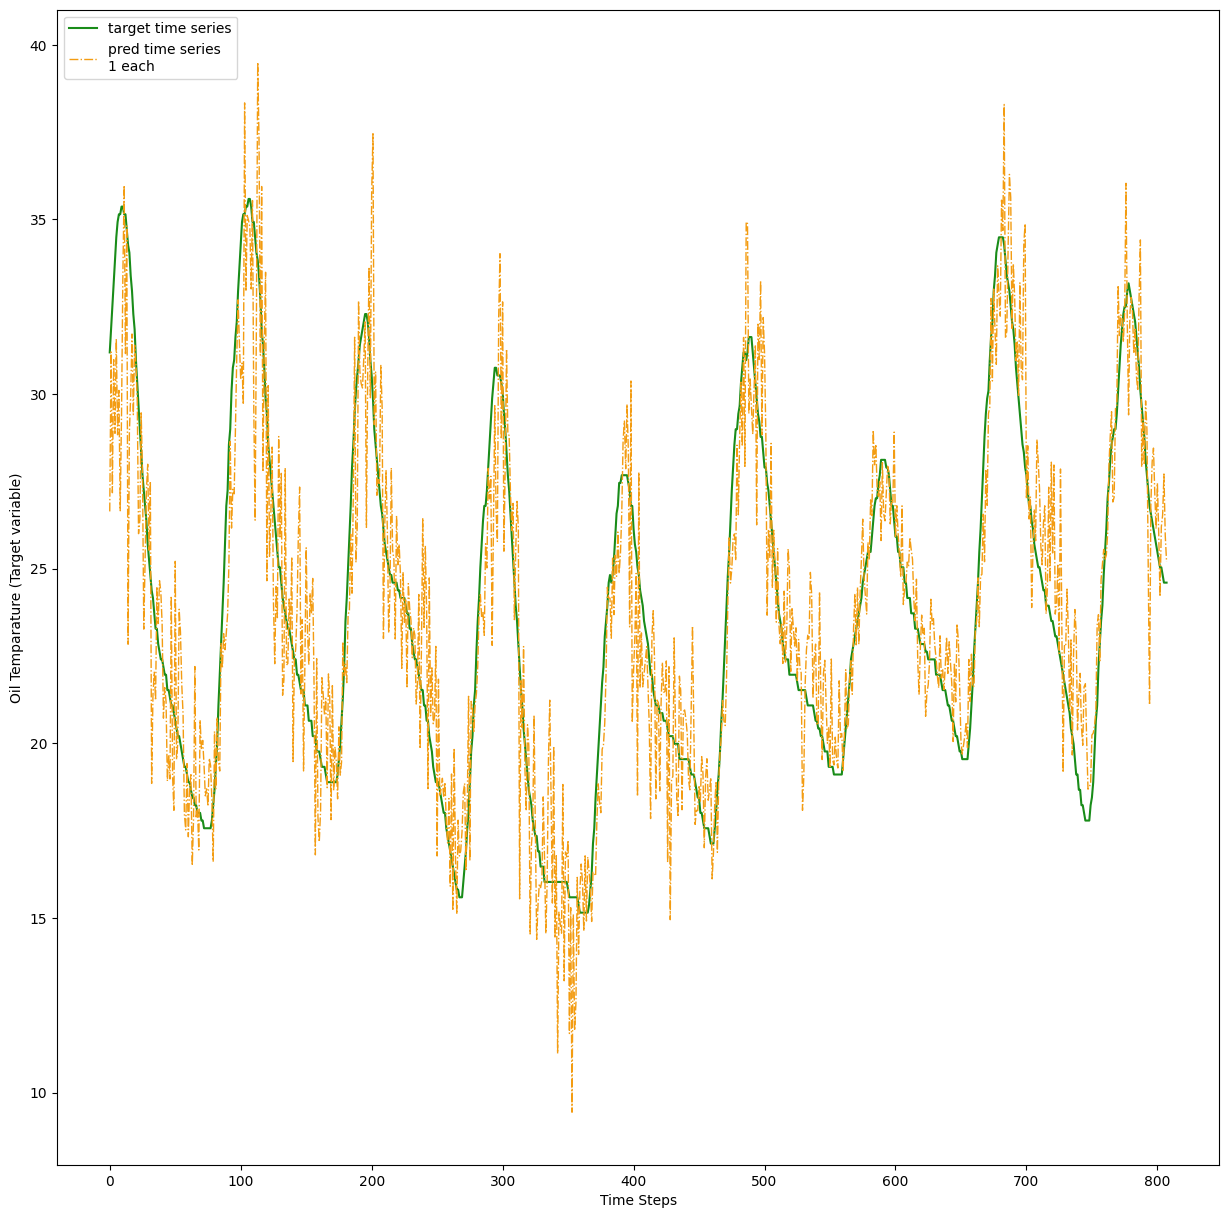

In [18]:
plot_multistep_forecast(test_data=test_data,  neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)

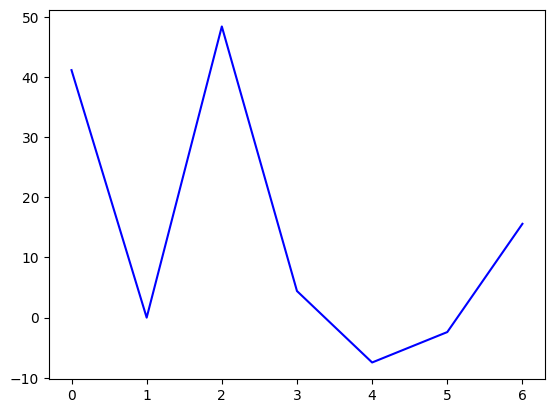

In [6]:
import matplotlib.pyplot as plt
neti = net.eval()
for i, (inputs, targets) in enumerate(test_data): 
    if i == 400: 
        break
    else: 
        output = neti(inputs)

plt.plot(output[1,:].tolist(), 'g')
plt.plot(targets[1,0,:].tolist(), 'b')

#### Dlinear

In [7]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'dlinear'
            )

test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)
evaluate_on_test_data(test_data = test_data, neural_net = net)

NameError: name 'val_df' is not defined

#### RLMP

Random seed set as 42
RMLP activated
Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 5000 : 34.15103763961792
Current (running) training loss at iteration 10000 : 26.215125174427033
Current (running) training loss at iteration 15000 : 20.059809621302286
Current (running) training loss at iteration 20000 : 16.20290729264021
Current (running) training loss at iteration 25000 : 14.707261218910217
Current (running) training loss at iteration 30000 : 13.692369370698929

Epoch 0: 

Train metrics: -------
Running (training) loss is 12.882676473059057.
Training MAE is 0.9050180617034954.
Training MSE is 12.951467582087405.
Training MAPE is 60587659.24700862.

Val metrics: -------
Running (validation) loss is 7.078883362597772.
Validation MAE is 0.7104712083536874.
Validation MSE is 7.143642597744215.
Validation MAPE is 0.021140445516283024.
---------------------------
Current learning rate is : 5e-05
---------------------------
Current (running) training loss at iteration 5000 : 3.695407676792145
Current (running) training loss at i

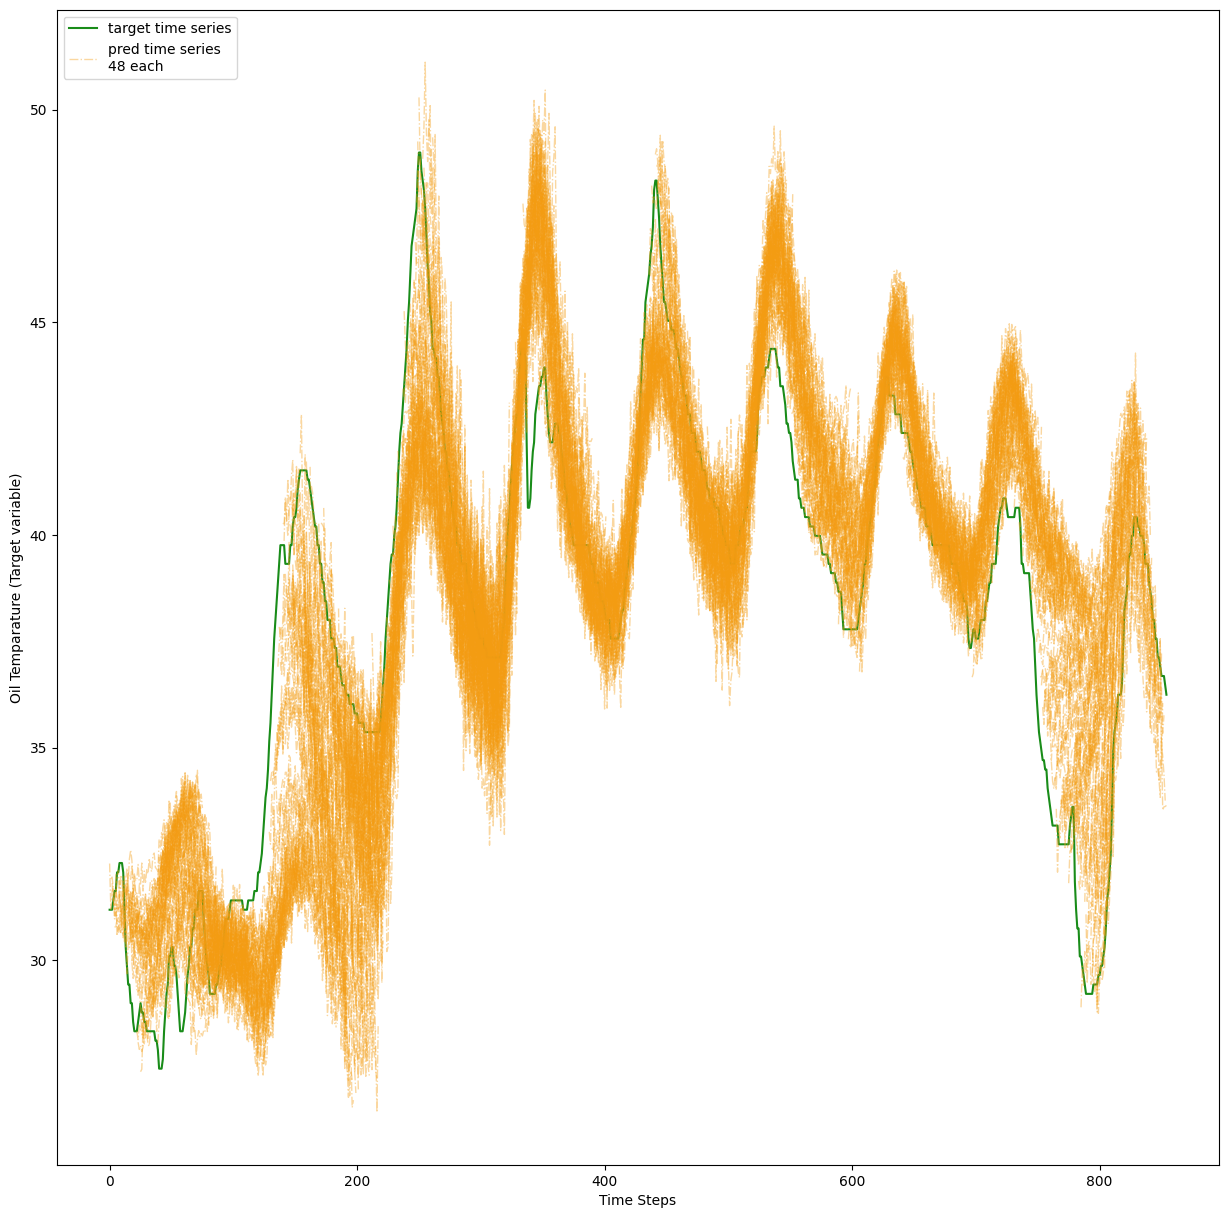

In [ ]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'rmlp'
            )

test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)
evaluate_on_test_data(test_data = test_data, neural_net = net)